<a href="https://colab.research.google.com/github/R4HUL-ROY/Multimodal_feature_extraction/blob/main/Feature_Integration_Bert_MobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Integration

In [1]:
!pip install -q tensorflow_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, Adamax

# Read the dataset and merge Text and Image

In [2]:
img_data_root = pathlib.Path('/content/drive/MyDrive/Tobacco3482-jpg/')
print(img_data_root)
for item in img_data_root.iterdir():
  print(item)

print()

text_data_root = pathlib.Path('/content/drive/MyDrive/tobaco_OCR/')
print(text_data_root)
for item in text_data_root.iterdir():
  print(item)


/content/drive/MyDrive/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/ADVE
/content/drive/MyDrive/Tobacco3482-jpg/Form
/content/drive/MyDrive/Tobacco3482-jpg/Note
/content/drive/MyDrive/Tobacco3482-jpg/Email
/content/drive/MyDrive/Tobacco3482-jpg/News
/content/drive/MyDrive/Tobacco3482-jpg/Resume
/content/drive/MyDrive/Tobacco3482-jpg/Scientific
/content/drive/MyDrive/Tobacco3482-jpg/Memo
/content/drive/MyDrive/Tobacco3482-jpg/Report
/content/drive/MyDrive/Tobacco3482-jpg/Letter

/content/drive/MyDrive/tobaco_OCR
/content/drive/MyDrive/tobaco_OCR/Resume
/content/drive/MyDrive/tobaco_OCR/Memo
/content/drive/MyDrive/tobaco_OCR/Letter
/content/drive/MyDrive/tobaco_OCR/Report
/content/drive/MyDrive/tobaco_OCR/Email
/content/drive/MyDrive/tobaco_OCR/ADVE
/content/drive/MyDrive/tobaco_OCR/News
/content/drive/MyDrive/tobaco_OCR/Note
/content/drive/MyDrive/tobaco_OCR/Form
/content/drive/MyDrive/tobaco_OCR/Scientific


In [3]:
def get_corresponding_txtpath(img_path):
    return img_path.replace("Tobacco3482-jpg", "tobaco_OCR")[:-3] + "txt"
    

def get_file_paths_and_labels(img_data_root, text_data_root):
     img_paths = [str(path) for path in img_data_root.glob('*/*.jpg')]
     text_paths = [get_corresponding_txtpath(this_path) for this_path in img_paths]
     img_labels = [p.split("/")[-2] for p in img_paths]
     text_labels = [p.split("/")[-2] for p in text_paths]
     return img_paths, img_labels, text_paths, text_labels

img_paths, img_labels, text_paths, text_labels = get_file_paths_and_labels(img_data_root, text_data_root)
print(len(img_paths))
print(len(img_labels))
print(len(text_paths))
print(len(text_labels))


3482
3482
3482
3482


In [4]:
def get_text_from_path(path):
    with open(path) as f:
        lines = f.readlines()
        lines  = ' '.join(lines)
        f.close()
    return lines

out_text = get_text_from_path('/content/drive/MyDrive/tobaco_OCR/ADVE/0000435350.txt') 
# out_text = preprocess_text(out_text)
print(out_text)


 TE che fitm
 m66400 7127
 KOOLS are the only cigarettes that taste
 good when you have &® cold. They taste even
 better when you don't.
 Job No, K-2978
 ‘Mevapapars—300 iner—Mareh & April, 1956
 (5 9-4 in 4 108 ines) Pinel Proof (7) March 15, 1956



In [5]:
# text_containts = [get_text_from_path(this_path) for this_path in text_paths]
text_contains = []

c= 0 
for i, this_path in enumerate(text_paths):
    text_contains.append(get_text_from_path(this_path))
    print(c)
    c +=1 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [21]:
df = pd.DataFrame(list(zip(text_paths, text_contains, img_paths, img_labels)),
               columns =['text_paths','texts', 'img_paths', 'data_label'])

# Merged Dataframe
df.head()

,text_paths,texts,img_paths,data_label
0,/content/drive/MyDrive/tobaco_OCR/ADVE/0000136...,\n \n \n \n A Mpertant as yar\n sesiye teaeter...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
1,/content/drive/MyDrive/tobaco_OCR/ADVE/0000435...,\n TE che fitm\n m66400 7127\n KOOLS are the o...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
2,/content/drive/MyDrive/tobaco_OCR/ADVE/0030049...,SR Onrel ules cee\n Nee dss\n The one tales WT...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
3,/content/drive/MyDrive/tobaco_OCR/ADVE/0000556...,so ARN Rr nr\n BWR Ga ||\n Vending Operators\n...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
4,/content/drive/MyDrive/tobaco_OCR/ADVE/0349627...,\n &\n BR. :\n er non\n be 4\n op Re eo eee ee...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03...,ADVE


In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['data_label']= le.fit_transform(df['data_label'])
df.head()

,text_paths,texts,img_paths,data_label
0,/content/drive/MyDrive/tobaco_OCR/ADVE/0000136...,\n \n \n \n A Mpertant as yar\n sesiye teaeter...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
1,/content/drive/MyDrive/tobaco_OCR/ADVE/0000435...,\n TE che fitm\n m66400 7127\n KOOLS are the o...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
2,/content/drive/MyDrive/tobaco_OCR/ADVE/0030049...,SR Onrel ules cee\n Nee dss\n The one tales WT...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
3,/content/drive/MyDrive/tobaco_OCR/ADVE/0000556...,so ARN Rr nr\n BWR Ga ||\n Vending Operators\n...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
4,/content/drive/MyDrive/tobaco_OCR/ADVE/0349627...,\n &\n BR. :\n er non\n be 4\n op Re eo eee ee...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03...,0


In [8]:
# 20% for test
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df["data_label"].values, random_state=42)
# 10% for validation
test_df, val_df = train_test_split(test_df, test_size=0.5, stratify=test_df["data_label"].values, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2437
Total validation examples: 523
Total test examples: 522


In [9]:
def dataframe_to_dataset(dataframe):
    columns = ["text_paths","texts", "img_paths", "data_label"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("data_label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds



In [10]:
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, (224, 224))

    return image


def preprocess_text(text):
    preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    bert_preprocess_model = hub.KerasLayer(preprocess_url)
    text = tf.convert_to_tensor([text])
    output = bert_preprocess_model(text)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image = preprocess_image(sample["img_paths"])
    text = preprocess_text(sample["texts"])
    return {"image_inputs": image,  "text_inputs": text}

In [11]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

In [12]:
train_ds

<PrefetchDataset element_spec=({'image_inputs': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'text_inputs': {'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [13]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [14]:
def create_text_encoder(num_projection_layers, text_projection_dims, dropout_rate, trainable=False):

    # preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2"
    # bert_preprocess_model = hub.KerasLayer(preprocess_url)
    bert_model = hub.KerasLayer(encoder_url)
    # text_projection_dims = 128

    # Set the trainability of the base encoder.
    bert_model.trainable = trainable

    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_inputs")

    # preprocessed_input = bert_preprocess_model(inputs)
    embeddings = bert_model(inputs)["pooled_output"]

    outputs = project_embeddings(embeddings, num_projection_layers, text_projection_dims, dropout_rate)

    return keras.Model(inputs, outputs, name="text_encoder")

In [15]:
def create_vision_encoder(num_projection_layers, img_projection_dims, dropout_rate, trainable=False):
    img_shape=(224,224,3)
    class_count = len(set(df['data_label']))
    neurons=512
    dropout=.2
    seed_value = 42


    base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet') 
    #   if freeze:
    base_model.trainable=True

    x=base_model.output
    x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99 , epsilon=0.001 )(x)
    x =tf.keras.layers.Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform())(x)
    x=tf.keras.layers.Dropout(rate=dropout, seed=seed_value)(x)
    x=tf.keras.layers.Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform())(x)
    x=tf.keras.layers.Dropout(rate=dropout, seed=seed_value)(x)
    x = keras.layers.LayerNormalization()(x)
    model=Model(inputs=base_model.input, outputs= x)

    
    #   for i,layer in enumerate(base_model.layers):
    #     print(i,layer.name)     
    
    # Set the trainability of the base encoder.
    for layer in base_model.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_inputs = keras.Input(shape=(224, 224, 3), name="image_inputs")
    preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(image_inputs)

    embeddings = model(preprocessed_image)

    outputs = project_embeddings(
            embeddings, num_projection_layers, img_projection_dims, dropout_rate
        )
    
    # Create the vision encoder model.
    return keras.Model(image_inputs, outputs, name="vision_encoder")

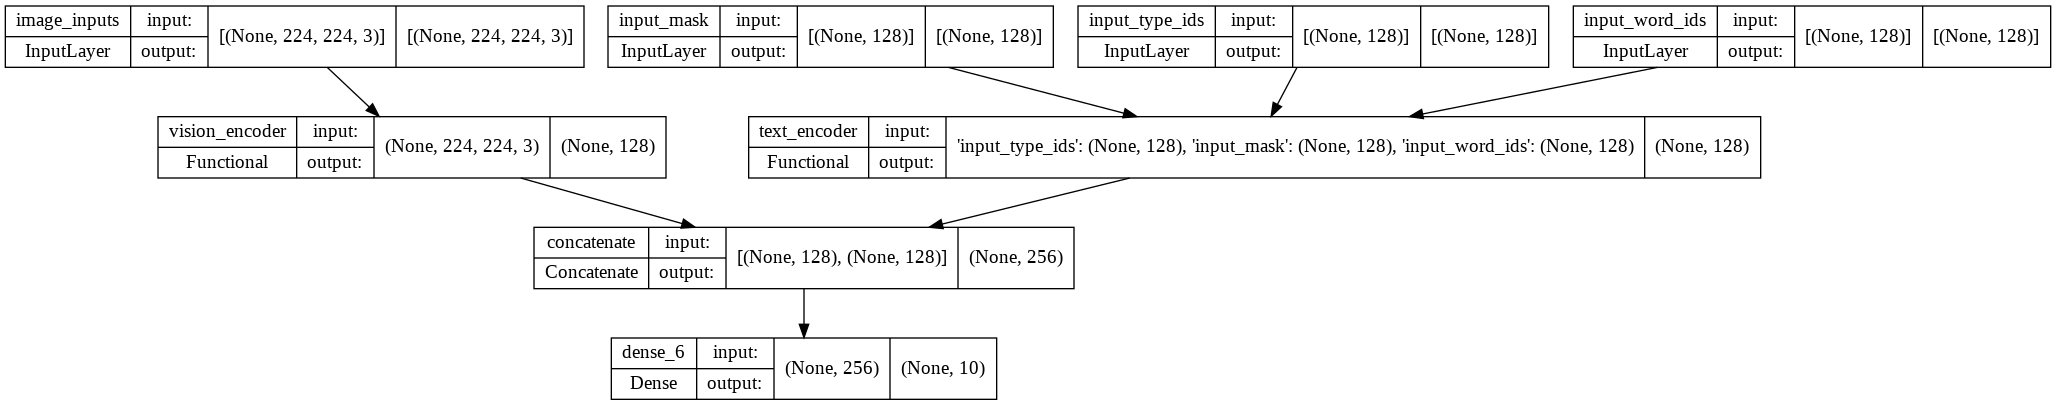

In [16]:
def create_multimodal_model(
    num_projection_layers=1,
    img_projection_dims=128,
    text_projection_dims=128,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images and text as inputs.
    image_inputs = keras.Input(shape=(224, 224, 3), name="image_inputs")
    # text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_inputs")

    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(num_projection_layers, img_projection_dims, dropout_rate, vision_trainable)
    text_encoder = create_text_encoder(num_projection_layers, text_projection_dims, dropout_rate, text_trainable)
    # print(keras.utils.plot_model(text_encoder, show_shapes=True))

    # Fetch the embedding projections.
    vision_projections = vision_encoder(image_inputs)
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(10, activation="softmax")(concatenated)
    return keras.Model([image_inputs, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [17]:
lr = 0.001
multimodal_model.compile(
    Adamax(learning_rate=lr), loss="sparse_categorical_crossentropy", metrics="accuracy"
)

In [18]:
history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=20)

Epoch 1/20
77/77 [==============================] - 103s 1s/step - loss: 19.2866 - accuracy: 0.5523 - val_loss: 16.3921 - val_accuracy: 0.6635
Epoch 2/20
77/77 [==============================] - 18s 238ms/step - loss: 14.1201 - accuracy: 0.7891 - val_loss: 12.8562 - val_accuracy: 0.7304
Epoch 3/20
77/77 [==============================] - 18s 239ms/step - loss: 11.3951 - accuracy: 0.8769 - val_loss: 10.7898 - val_accuracy: 0.7323
Epoch 4/20
77/77 [==============================] - 18s 238ms/step - loss: 9.4758 - accuracy: 0.9434 - val_loss: 9.3090 - val_accuracy: 0.7514
Epoch 5/20
77/77 [==============================] - 18s 237ms/step - loss: 8.0167 - accuracy: 0.9672 - val_loss: 8.1150 - val_accuracy: 0.7533
Epoch 6/20
77/77 [==============================] - 18s 239ms/step - loss: 6.8621 - accuracy: 0.9733 - val_loss: 7.0911 - val_accuracy: 0.7514
Epoch 7/20
77/77 [==============================] - 18s 239ms/step - loss: 5.8950 - accuracy: 0.9873 - val_loss: 6.2742 - val_accuracy: 0.

In [19]:
multimodal_model.evaluate(test_ds, batch_size=32, verbose=2, return_dict=True)

17/17 - 24s - loss: 3.1005 - accuracy: 0.7414 - 24s/epoch - 1s/step


{'accuracy': 0.7413793206214905, 'loss': 3.1004672050476074}

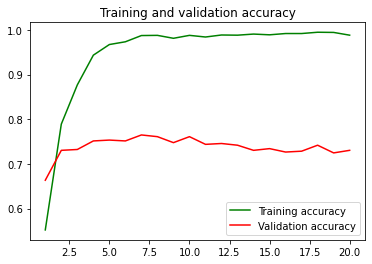

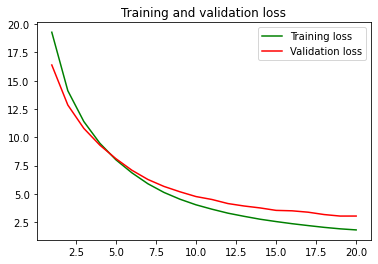

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()